# DSL Clickstream - Task 2

For the Task 2 we'll be using the same data layout we have setup previously. We will need to parse the files and create a pipeline that will generate the four tables from our star schema.

This should be straightforward to acomplish. Let's begin by defining some helper variables.

In [1]:
import os

# Fetch the working project_id
PROJECT_ID = !gcloud config get-value project 2>/dev/null
PROJECT_ID = PROJECT_ID[0].strip()
os.environ["PROJECT_ID"] = PROJECT_ID

# Reuse the Task 1 raw bucket data copy we had previously
RAWDATA_BUCKET = f"clickstream-raw-{PROJECT_ID}"
os.environ["RAWDATA_BUCKET"] = RAWDATA_BUCKET

# Deadletter bucket to store errors while loading
DEADLETTER_BUCKET = f"clickstream-deadletter-{PROJECT_ID}"
os.environ["DEADLETTER_BUCKET"] = DEADLETTER_BUCKET

# Temporary bucket to store artifacts during pipeline execution and data loading
TEMPORARY_BUCKET = f"clickstream-temp-{PROJECT_ID}"
os.environ["TEMPORARY_BUCKET"] = TEMPORARY_BUCKET

# Lake dataset
LAKE_DATASET=f"{PROJECT_ID}:clickstream_lake"
os.environ["LAKE_DATASET"] = LAKE_DATASET

# DW dataset
# Lake dataset
DW_DATASET=f"{PROJECT_ID}:clickstream_dw"
os.environ["DW_DATASET"] = DW_DATASET

# Target pipeline code
solution_dir = "../solutions/task2"
solution_schemas = f"{solution_dir}/schemas.py"
solution_file = f"{solution_dir}/batch_pipeline.py"

print("Running on project: ", PROJECT_ID)

Running on project:  bill-arki1-25-4


In [2]:
os.makedirs(solution_dir, exist_ok=True)

In [3]:
%%bash
# Check if buckets for raw data and errors exists, otherwise create them
echo "Checkin storage for RAW DATA..."
gcloud storage buckets describe gs://${RAWDATA_BUCKET} --format='value(name)' 2>/dev/null \
  || gcloud storage buckets create gs://${RAWDATA_BUCKET}
echo "Checkin storage for DEADLETTER DATA..."
gcloud storage buckets describe gs://${DEADLETTER_BUCKET} --format='value(name)' 2>/dev/null \
  || gcloud storage buckets create gs://${DEADLETTER_BUCKET}
echo "Checkin storage for TEMP DATA..."
gcloud storage buckets describe gs://${TEMPORARY_BUCKET} --format='value(name)' 2>/dev/null \
  || gcloud storage buckets create gs://${TEMPORARY_BUCKET} --soft-delete-policy.retention-duration 0

# Check if the datasets exist, otherwise create them
echo "Checkin storage for LAKE DATASET..."
bq ls ${LAKE_DATASET} 2>/dev/null || bq mk ${LAKE_DATASET}
echo "Checkin storage for DW DATASET..."
bq ls ${DW_DATASET} 2>/dev/null || bq mk ${DW_DATASET}

Checkin storage for RAW DATA...
clickstream-raw-bill-arki1-25-4
Checkin storage for DEADLETTER DATA...
clickstream-deadletter-bill-arki1-25-4
Checkin storage for TEMP DATA...
clickstream-temp-bill-arki1-25-4
Checkin storage for LAKE DATASET...
  tableId   Type    Labels   Time Partitioning   Clustered Fields  
 --------- ------- -------- ------------------- ------------------ 
  visits    TABLE                                                  
Checkin storage for DW DATASET...
      tableId        Type    Labels      Time Partitioning        Clustered Fields    
 ------------------ ------- -------- -------------------------- --------------------- 
  addtocart_events   TABLE            MONTH (field: timestamp)   session_key          
  pageview_events    TABLE            MONTH (field: timestamp)   session_key          
  purchase_events    TABLE            MONTH (field: timestamp)   session_key          
  sessions           TABLE                                       session_id, user_i

## Creating the pipeline and testing locally

Let's create the pipeline code and run it inside the notebook as a first test

In [4]:
%%writefile {solution_file}
#!/usr/bin/env python
import os
import sys
import logging
import hashlib
import json
import typing
import datetime
import google
from google.cloud import bigquery

import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions, SetupOptions, GoogleCloudOptions
from apache_beam.pvalue import TaggedOutput
from apache_beam.io import ReadFromText, WriteToText
from apache_beam.io.gcp.bigquery import WriteToBigQuery, BigQueryDisposition

# Global settings
PROJECT_ID = os.getenv("PROJECT_ID")

# Bucket names derive from PROJECT_ID environment variable
RAWDATA_BUCKET = os.getenv("RAWDATA_BUCKET", default=f"clickstream-raw-{PROJECT_ID}")
DEADLETTER_BUCKET = os.getenv("DEADLETTER_BUCKET", default=f"clickstream-deadletter-{PROJECT_ID}")
TEMPORARY_BUCKET = os.getenv("TEMPORARY_BUCKET", default=f"clickstream-tmp-{PROJECT_ID}")

# Bigquery Schemas
RAW = {
    "fields": [
        {"name": "session_id", "type": "STRING", "mode": "NULLABLE"},
        {"name": "user_id", "type": "STRING", "mode": "NULLABLE"},
        {"name": "device_type", "type": "STRING", "mode": "NULLABLE"},
        {"name": "geolocation", "type": "STRING", "mode": "NULLABLE"},
        {"name": "user_agent", "type": "STRING", "mode": "NULLABLE"},
        {"name": "events", "type": "RECORD", "mode": "REPEATED",
            "fields": [
                {"name": "event", "type": "RECORD", "mode": "NULLABLE",
                     "fields": [
                        {"name": "event_type", "type": "STRING", "mode": "NULLABLE"},
                        {"name": "timestamp", "type": "TIMESTAMP", "mode": "NULLABLE"},
                        {"name": "details", "type": "RECORD", "mode": "NULLABLE",
                             "fields": [
                                 {"name": "page_url", "type": "STRING", "mode": "NULLABLE"},
                                 {"name": "referrer_url", "type": "STRING", "mode": "NULLABLE"},
                                 {"name": "product_id", "type": "STRING", "mode": "NULLABLE"},
                                 {"name": "product_name", "type": "STRING", "mode": "NULLABLE"},
                                 {"name": "category", "type": "STRING", "mode": "NULLABLE"},
                                 {"name": "price", "type": "FLOAT", "mode": "NULLABLE"},
                                 {"name": "quantity", "type": "INTEGER", "mode": "NULLABLE"},
                                 {"name": "order_id", "type": "STRING", "mode": "NULLABLE"},
                                 {"name": "amount", "type": "FLOAT", "mode": "NULLABLE"},
                                 {"name": "currency", "type": "STRING", "mode": "NULLABLE"},
                                 {"name": "items", "type":"RECORD", "mode": "REPEATED",
                                      "fields": [
                                          {"name":"product_id", "type":"STRING", "mode": "NULLABLE"},
                                          {"name":"product_name", "type":"STRING", "mode": "NULLABLE"},
                                          {"name":"category", "type":"STRING", "mode": "NULLABLE"},
                                          {"name":"price", "type":"FLOAT", "mode": "NULLABLE"},
                                          {"name":"quantity", "type":"INTEGER", "mode": "NULLABLE"},
                                      ],
                                 },
                             ],
                        },
                     ],
                },
            ],
        },
    ],
}

SESSION = {
    "fields": [
        {"name": "session_key","type": "STRING","mode": "NULLABLE"},
        {"name": "session_id","type": "STRING","mode": "NULLABLE"},
        {"name": "user_id","type": "STRING","mode": "NULLABLE" },
        {"name": "user_agent","type": "STRING","mode": "NULLABLE"},
        {"name": "geolocation", "type": "STRING", "mode": "NULLABLE"},
        {"name": "device_type","type": "STRING","mode": "NULLABLE"},
    ]
}

PAGEVIEW = {
    "fields": [
        {"name": "session_key", "type": "STRING", "mode": "NULLABLE"},
        {"name": "timestamp", "type": "TIMESTAMP", "mode": "NULLABLE"},
        {"name": "page_url", "type": "STRING", "mode": "NULLABLE"},
        {"name": "referrer_url", "type": "STRING", "mode": "NULLABLE"},
    ]
}

ADDTOCART = {
    "fields": [
        {"name": "session_key", "type": "STRING", "mode": "NULLABLE"},
        {"name": "timestamp", "type": "TIMESTAMP", "mode": "NULLABLE"},
        {"name": "product_id", "type": "STRING", "mode": "NULLABLE"},
        {"name": "product_name", "type": "STRING", "mode": "NULLABLE"},
        {"name": "category", "type": "STRING", "mode": "NULLABLE"},
        {"name": "quantity", "type": "INTEGER", "mode": "NULLABLE"},
        {"name": "price", "type": "FLOAT", "mode": "NULLABLE"},
    ]
}

PURCHASE = {
    "fields": [
        {"name": "session_key", "type": "STRING", "mode": "NULLABLE"},
        {"name": "timestamp", "type": "TIMESTAMP", "mode": "NULLABLE"},
        {"name": "order_id", "type": "STRING", "mode": "NULLABLE"},
        {"name": "currency", "type": "STRING", "mode": "NULLABLE"},
        {"name": "amount", "type": "FLOAT", "mode": "NULLABLE"},
        {"name": "items", "type": "RECORD", "mode": "REPEATED",
            "fields": [
                {"name": "quantity", "type": "INTEGER", "mode": "NULLABLE"},
                {"name": "price", "type": "FLOAT", "mode": "NULLABLE"},
                {"name": "category", "type": "STRING", "mode": "NULLABLE"},
                {"name": "product_name", "type": "STRING", "mode": "NULLABLE"},
                {"name": "product_id", "type": "STRING", "mode": "NULLABLE"}
            ]
        },
    ]
}

class Options(PipelineOptions):
    """ Options provide custom options for the batch pipeline execution. """
    @classmethod
    def _add_argparse_args(cls, parser):
        parser.add_argument("--src-bucket", default=f"gs://{RAWDATA_BUCKET}",
                            help="The data bucket to read from")
        parser.add_argument("--temp-bucket", default=f"gs://{TEMPORARY_BUCKET}",
                            help="The temporary bucket to write artifacts into")
        parser.add_argument("--lake-dataset", default=f"{PROJECT_ID}:clickstream_lake",
                            help="The dataset to be used for the Data Lake")
        parser.add_argument("--dw-dataset", default=f"{PROJECT_ID}:clickstream_dw",
                            help="The dataset to be used for the Data Wharehouse")
        parser.add_argument("--deadletter-bucket", default=f"gs://{DEADLETTER_BUCKET}",
                            help="The bucket where to store unparseable data and the errors")
        parser.add_argument("--force-recreate", action="store_true",
                            help="Delete the tables before running the Pipeline in order to recreate them.")

def parse_json(line):
    return json.loads(line)
        
def new_session_key(session):
    """
    session_key calculates a unique session key from the session info.

    Due to possible data duplication, we are using the tuple (session_id, user_id, device)
    as input to SHA256 hash function, and the resulting hex representation is the session_key.
    """
    data = [
        session["session_id"],
        session["user_id"],
        session["device_type"]
    ]
    return hashlib.sha256(":".join(data).encode("utf-8")).hexdigest()

def parse_event(session_key, session_data):
    """
    parse_event will unnest the data from the raw schema into the proper event type schema.
    
    It returns 'invalid', raw_data in case the event type is not a known one.
    """
    event = session_data["event"]
    details = event["details"]
    
    if event["event_type"] == "page_view":
        return "page_view", {
            "session_key": session_key,
            "timestamp": event["timestamp"],
            "page_url": details["page_url"],
            "referrer_url": details["referrer_url"]
        }
    elif event["event_type"] == "add_item_to_cart":
        return "add_item_to_cart", {
            "session_key": session_key,
            "timestamp": event["timestamp"],
            "product_id": details["product_id"],
            "product_name": details["product_name"],
            "category": details["category"],
            "price": details["price"],
            "quantity": details["quantity"]
        }
    elif event["event_type"] == "purchase":
        #TODO(ronoaldo): fix the amount rounding error from the input
        return "purchase", {
            "session_key": session_key,
            "timestamp": event["timestamp"],
            "order_id": details["order_id"],
            "amount": details["amount"],
            "currency": details["currency"],
            "items": details["items"],
        }
    else:
        "invalid", event

def parse_sessions(line):
    """
    parse_sessions will parse all the session data received as a JSONL string.
    
    The sessions will be output into a tagged output called 'sessions'.
    Additionally, each event will be output into separeted pcollections, according to the event type.
    
    Invalid events or unknown event_types will be rejected into the _invalid output pcollection.
    """
    try:
        # Convert the raw session to JSON and yield the session table row
        session = json.loads(line)
        session_key = new_session_key(session)
        yield {
            "session_key": session_key,
            "session_id": session["session_id"],
            "user_id": session["user_id"],
            "device_type": session["device_type"],
            "geolocation": session["geolocation"],
            "user_agent": session["user_agent"],
        }
    except Exception as e:
        yield TaggedOutput("invalid", f"error={e}; line={line}")
        # Potentially invalid JSON found, so let's ignore the record entirely and return
        return

    # For each event, emit the appropriate event by type
    for session_data in session["events"]:
        try:
            event_type, event = parse_event(session_key, session_data)
            yield TaggedOutput(event_type, event)
        except Exception as e:
            yield TaggedOutput("invalid", f"error={e}, session_data={session_data}")

class RecreateTable(beam.PTransform):
    """
    Custom PTransform to overwrite a Bigquery table.
    
    Defaults to partition by montly timestamp and no clustering.
    """
    def __init__(self, table=None, schema=None, partition_by="timestamp", partition_type="MONTH", cluster_by=None):
        self.table = table
        self.schema = schema
        
        self.bq_params = {}
        if partition_by is not None:
            self.bq_params["timePartitioning"] = {"type": partition_type, "field": partition_by}
        if cluster_by is not None:
            cluster_by = cluster_by if isinstance(cluster_by, (list, tuple)) else [cluster_by]
            self.bq_params["clustering"] = {"fields": cluster_by}

    def default_label(self):
        table_name = self.table.split(".")[-1]
        return str(f"{self.__class__.__name__}_{table_name}")

    def expand(self, pcoll):
        return pcoll | WriteToBigQuery(
            table=self.table,
            schema=self.schema or "SCHEMA_AUTODETECT",
            create_disposition=BigQueryDisposition.CREATE_IF_NEEDED,
            write_disposition=BigQueryDisposition.WRITE_TRUNCATE,
            method="FILE_LOADS",
            additional_bq_parameters=self.bq_params
        )

def delete_tables(table_ids=[]):
    LOG = logging.getLogger("batch_pipeline")
    
    client = bigquery.Client()
    for table_id in table_ids:
        LOG.info("Removing %s ...", table_id)
        try:
            client.delete_table(table_id)
        except google.api_core.exceptions.NotFound:
            pass
    
def run_pipeline(args):
    """
    run_pipeline initializes the pipeline and executes according to the arguments provided.
    """
    LOG = logging.getLogger("batch_pipeline")
    LOG.setLevel(logging.DEBUG)
    
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
    
    LOG.info("Parsing arguments ...")
    opts = Options(flags=args)
    # Let's simplify the launching args and set a default temp_bucket when running the job
    opts.view_as(GoogleCloudOptions).temp_location = f"{opts.temp_bucket}/{timestamp}/"
    
    # This is required to avoid NameError when running on Dataflow.
    # Ref: https://cloud.google.com/dataflow/docs/guides/common-errors#name-error
    opts.view_as(SetupOptions).save_main_session = True

    # Also, let's prepare the deadletter timestamped folder
    dead_letter_folder = f"{opts.deadletter_bucket}/{timestamp}/"
    LOG.info("Parsed arguments %s", str(opts))

    # Initializes the pipeline
    LOG.info("Preparing the pipeline graph ...")
    pipeline = beam.Pipeline(options=opts)
    
    # Read from Cloud Storage
    json_lines = pipeline | "LoadJSONFiles" >> ReadFromText(opts.src_bucket + "/*.jsonl")
    
    # Load the raw data after parsing into a raw bucket for our data lake
    json_lines | "ParseRawAsJSON" >> beam.Map(parse_json) | RecreateTable(
        table=f"{opts.lake_dataset}.visits",
        schema=RAW,
        cluster_by=None,
        partition_by=None)
    
    # Parse the session data into multiple tagged outputs
    parsed = json_lines | "ParseSessionData" >> beam.ParDo(parse_sessions).with_outputs(
        "page_view", "add_item_to_cart", "purchase", "invalid", main="session"
    )
    
    # Send errors to dead letter bucket
    parsed.invalid | "InvalidToDeadLetter" >> WriteToText(dead_letter_folder)
    
    # Store the sessions
    parsed.session | RecreateTable(
        table=f"{opts.dw_dataset}.sessions",
        schema=SESSION,
        partition_by=None,
        cluster_by=["session_id", "user_id"])
    
    # Store the events
    parsed.page_view | RecreateTable(
        table=f"{opts.dw_dataset}.pageview_events",
        schema=PAGEVIEW,
        cluster_by="session_key")
    parsed.add_item_to_cart | RecreateTable(
        table=f"{opts.dw_dataset}.addtocart_events",
        schema=ADDTOCART,
        cluster_by="session_key")
    parsed.purchase | RecreateTable(
        table=f"{opts.dw_dataset}.purchase_events",
        schema=PURCHASE,
        cluster_by="session_key")
    
    # If drastic schema changes are needed, the disposition of CREATE_IF_NEEDED does not
    # forcibly recreate the table. So if we change the clustering keys, the easier way is
    # to delete then recreate the table.
    if opts.force_recreate == True:
        LOG.info("force_recreate: removing removing old versions of tables")
        delete_tables(table_ids=[
            f"{opts.lake_dataset.replace(':','.')}.visits",
            f"{opts.dw_dataset.replace(':','.')}.sessions",
            f"{opts.dw_dataset.replace(':','.')}.pageview_events",
            f"{opts.dw_dataset.replace(':','.')}.addtocart_events",
            f"{opts.dw_dataset.replace(':','.')}.purchase_events"])

    # Run the pipeline
    LOG.info("Launching the pipeline ...")
    result = pipeline.run()
    result.wait_until_finish()
    LOG.info("Execution finished.")
    return result

if __name__ == "__main__":
    result = run_pipeline(sys.argv[1:])
    print(result)

Overwriting ../solutions/task2/batch_pipeline.py


## Testing the Pipeline

Checking if it "parses" with --help as a fast way to spot simple syntax errors.

In [5]:
!python3 {solution_file} --help

usage: batch_pipeline.py [-h] [--src-bucket SRC_BUCKET]
                         [--temp-bucket TEMP_BUCKET]
                         [--lake-dataset LAKE_DATASET]
                         [--dw-dataset DW_DATASET]
                         [--deadletter-bucket DEADLETTER_BUCKET]
                         [--force-recreate]

options:
  -h, --help            show this help message and exit
  --src-bucket SRC_BUCKET
                        The data bucket to read from
  --temp-bucket TEMP_BUCKET
                        The temporary bucket to write artifacts into
  --lake-dataset LAKE_DATASET
                        The dataset to be used for the Data Lake
  --dw-dataset DW_DATASET
                        The dataset to be used for the Data Wharehouse
  --deadletter-bucket DEADLETTER_BUCKET
                        The bucket where to store unparseable data and the
                        errors
  --force-recreate      Delete the tables before running the Pipeline in order
                 

Now let's do a locall run of the code with the pipeline implemented:

In [10]:
!rm -rf beam-temp-* output-*
!python3 {solution_file}

INFO:batch_pipeline:Parsed arguments Options(deadletter_bucket=gs://clickstream-raw-bill-arki1-25-4, dw_dataset=bill-arki1-25-4:clickstream_dw, force_recreate=False, lake_dataset=bill-arki1-25-4:clickstream_lake, src_bucket=gs://clickstream-raw-bill-arki1-25-4, temp_bucket=gs://clickstream-temp-bill-arki1-25-4)
INFO:batch_pipeline:Preparing the pipeline graph ...
INFO:batch_pipeline:Launching the pipeline ...
INFO:batch_pipeline:Execution finished.


## Run on Dataflow

Now that the code is properly running, let's submit the JOB to the Dataflow runtime.

First we need to create another file for setuptools to identify our packages since we split our code into two files.

In [6]:
!python3 {solution_file} --runner=DataflowRunner --project={PROJECT_ID} --region=us-central1

INFO:batch_pipeline:Parsed arguments Options(deadletter_bucket=gs://clickstream-deadletter-bill-arki1-25-4, dw_dataset=bill-arki1-25-4:clickstream_dw, force_recreate=False, lake_dataset=bill-arki1-25-4:clickstream_lake, src_bucket=gs://clickstream-raw-bill-arki1-25-4, temp_bucket=gs://clickstream-temp-bill-arki1-25-4)
INFO:batch_pipeline:Preparing the pipeline graph ...
INFO:batch_pipeline:Launching the pipeline ...
INFO:batch_pipeline:Execution finished.
<DataflowPipelineResult 2025-04-22_19_47_05-15068148223962366276 DONE>


## Possible Improvements

During testing we had some issues trying to configure the code to be split into multiple files in Python. This required us to use a few tricks, like setting up the pipeline to always pickle the global state (otherwise, functions defined by the script would not load).

An improvement for a future revision would be to split the code into multiple files and use the setup.py file to specify the pipeline as a python Module. Futher improvements would be to allow the pipeline to be packaged and implemented as a redistributable and possibly reusable Python module. This would allow for the code to be properly executed in Dataflow without the name errors we experienced.

# Final Data Layout

We finished Task 2 with the following setup for a slighlyt revised data architecture, now created via a batch Beam pipeline:

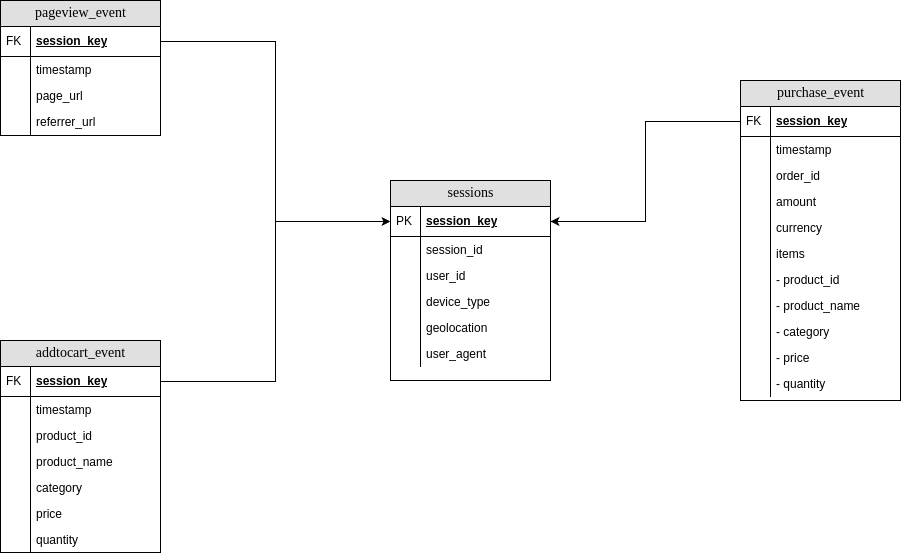

And this is the final pipeline layout, beautifuly executing with green boxes and all of that ❤️

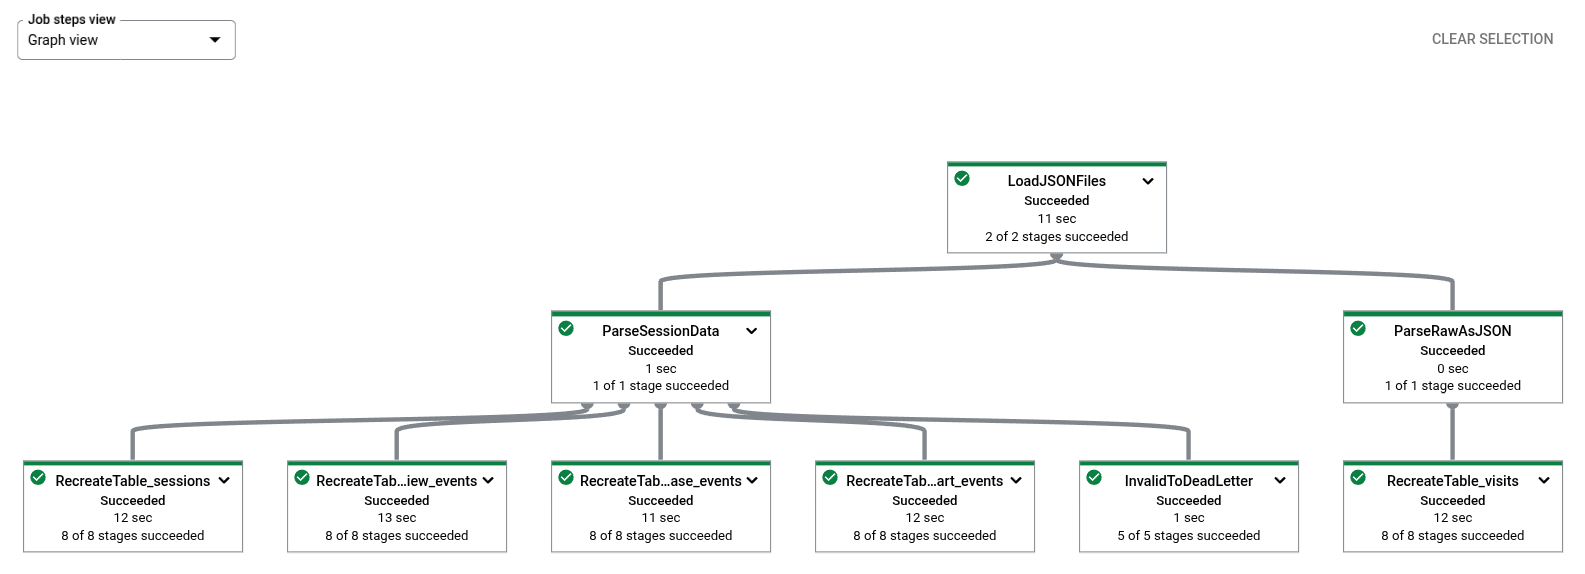